# Primero vamos a cargar este primer dataset

In [ ]:
from google.colab import files
files.upload() # aquí subimos el json de la api de kaggle

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"giovannicapotegarcia","key":"f13d3fd93e887cc640ac0d30b7fc0f7f"}'}

In [ ]:
!pip install -q kaggle


In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json # lo guardamos

# Dataset Principal ya Fusionado

In [ ]:
!kaggle datasets download -d sabersakin/brainmri

Dataset URL: https://www.kaggle.com/datasets/sabersakin/brainmri
License(s): unknown
 81% 243M/299M [00:00<00:00, 1.29GB/s]
100% 299M/299M [00:00<00:00, 1.28GB/s]


In [ ]:
!unzip -q brainmri.zip -d dataset_final

# Vamos a explorar sus carpetas

In [ ]:
import os
import numpy as np
from tqdm import tqdm

In [ ]:
for root, dirs, files in os.walk("dataset_final"):
    print(f"\n📁 Carpeta: {root}")
    for d in dirs:
        print(f"  📂 {d}")
    for f in files[:3]:
        print(f"  📄 {f}")


📁 Carpeta: dataset_final
  📂 test
  📂 Datasest Merged 1

📁 Carpeta: dataset_final/test
  📂 test

📁 Carpeta: dataset_final/test/test
  📄 g1.jpg
  📄 p1.jpg
  📄 nt1.jpg

📁 Carpeta: dataset_final/Datasest Merged 1
  📂 Datasest Merged 1

📁 Carpeta: dataset_final/Datasest Merged 1/Datasest Merged 1
  📂 pituitary
  📂 meningioma
  📂 glioma
  📂 notumor

📁 Carpeta: dataset_final/Datasest Merged 1/Datasest Merged 1/pituitary
  📄 Tr-pi_0944.jpg
  📄 3007.jpg
  📄 2163.jpg

📁 Carpeta: dataset_final/Datasest Merged 1/Datasest Merged 1/meningioma
  📄 240.jpg
  📄 m (69).jpg
  📄 m2 (9).jpg

📁 Carpeta: dataset_final/Datasest Merged 1/Datasest Merged 1/glioma
  📄 Tr-gl_0189.jpg
  📄 gg (421).jpg
  📄 1451.jpg

📁 Carpeta: dataset_final/Datasest Merged 1/Datasest Merged 1/notumor
  📄 Te-no_0286.jpg
  📄 Tr-no_0785.jpg
  📄 Tr-no_1519.jpg


# A continuación vamos a reestructurar nuestro dataset y vamos a dividir nuestras imágenes

In [ ]:
import os, shutil
from sklearn.model_selection import train_test_split

In [ ]:
base_dir = "dataset_final/Datasest Merged 1/Datasest Merged 1"
output_dir = "dataset_split_final"

# Crear carpetas base
for subset in ["train", "val", "test"]:
    os.makedirs(os.path.join(output_dir, subset), exist_ok=True)

# Listar solo carpetas de clases
classes = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]

for cls in classes:
    imgs = os.listdir(os.path.join(base_dir, cls))

    if len(imgs) < 3:
        print(f"⚠️ Clase '{cls}' tiene muy pocas imágenes ({len(imgs)}), se omitirá.")
        continue

    # Separar 15% para val+test
    train_files, temp_files = train_test_split(imgs, test_size=0.15, random_state=42)

    # De ese 15%, 1/3 será test (~5% total), 2/3 será val (~10% total)
    val_files, test_files = train_test_split(temp_files, test_size=1/3, random_state=42)

    # Crear carpetas de clase
    for subset in ["train", "val", "test"]:
        os.makedirs(os.path.join(output_dir, subset, cls), exist_ok=True)

    # Copiar imágenes
    for f in train_files:
        shutil.copy(os.path.join(base_dir, cls, f), os.path.join(output_dir, "train", cls))
    for f in val_files:
        shutil.copy(os.path.join(base_dir, cls, f), os.path.join(output_dir, "val", cls))
    for f in test_files:
        shutil.copy(os.path.join(base_dir, cls, f), os.path.join(output_dir, "test", cls))

In [ ]:
dataset_split = "dataset_split_final"  # ruta base

for split in ["train", "val", "test"]:
    print(f"\n📂 {split.upper()}")
    for cls in os.listdir(os.path.join(dataset_split, split)):
        count = len(os.listdir(os.path.join(dataset_split, split, cls)))
        print(f"  {cls}: {count} imágenes")


📂 TRAIN
  pituitary: 3049 imágenes
  meningioma: 2796 imágenes
  glioma: 3377 imágenes
  notumor: 2125 imágenes

📂 VAL
  pituitary: 359 imágenes
  meningioma: 329 imágenes
  glioma: 397 imágenes
  notumor: 250 imágenes

📂 TEST
  pituitary: 180 imágenes
  meningioma: 165 imágenes
  glioma: 199 imágenes
  notumor: 125 imágenes


Aunque tenemos desbalanceo luego haremos truquito

# YA TENEMOS PREPARADO NUESTRO DATASET PREPARADO PARA COMENZAR A TRABAJAR. EN ESTA OCASIÓN VOY A PROBAR A UTILIZAR EL MULTICLASE TRAS LOS RESULTADOS DECEPCIONANTES DEL BINARIO

En nuestro caso vamos a comenzar utilizando la EfficientNetB3

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, save_img
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.efficientnet import preprocess_input
import os
import pandas as pd
from sklearn.utils import resample

In [ ]:
import sys, tensorflow as tf
print(sys.version)
print("tensorflow:", tf.__version__)
print("tf.keras:", tf.keras.__version__)
import keras; print("keras (standalone):", keras.__version__)


3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
tensorflow: 2.19.0
tf.keras: 3.10.0
keras (standalone): 3.10.0


# Configuramos paths y parámetros (A PARTIR DE AQUÍ SI)

In [ ]:
# ===== Configuración =====
BATCH_SIZE = 32
IMG_SIZE = 300 #es el tamaño de EfficientNetB3
SEED = 42

# Setting seed for consistent results
tf.keras.utils.set_random_seed(SEED)
tf.random.set_seed(SEED)
np.random.seed(SEED)

In [ ]:
# Paths a tu dataset binario
DATASET_DIR = "dataset_split_final"
TRAIN_DIR = os.path.join(DATASET_DIR, "train")
VAL_DIR = os.path.join(DATASET_DIR, "val")
TEST_DIR = os.path.join(DATASET_DIR, "test")

Preprocesamiento y generadores

In [ ]:
# ===== Data augmentation seguro para imágenes médicas =====
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input, # esto es específico de la efficientNet
    rotation_range=10,             # rotación leve
    brightness_range=(0.85, 1.15), # variación de brillo moderada
    width_shift_range=0.02,
    height_shift_range=0.02,
    shear_range=0.0,
    zoom_range=0.05,               # zoom leve
    horizontal_flip=False,         # cambiar a True si lateralidad no importa
    vertical_flip=False,
    fill_mode="nearest"
)


val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [ ]:
# ===== Carga datasets sin oversampling (solo para obtener paths) =====
train_base = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=1,
    class_mode="categorical",
    shuffle=False,
    seed=SEED
)

val_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False,
    seed=SEED
)

# Vamos a balancear las clases de nuestro train

Lo siguiente nos va a permitir que cada clase salga el mismo número de veces aunque en nuestra base de datos tengamos clases desbalanceadas

In [ ]:
# === Partimos del train_base ===
x_paths = np.array(train_base.filepaths)
y_labels = np.array(train_base.classes)
classes = np.unique(y_labels)
max_count = max(np.bincount(y_labels))

balanced_paths = []
balanced_labels = []

# Oversampling para balancear primero
for cls in classes:
    cls_paths = x_paths[y_labels == cls]
    cls_labels = y_labels[y_labels == cls]

    cls_paths_resampled, cls_labels_resampled = resample(
        cls_paths,
        cls_labels,
        replace=True,
        n_samples=max_count,
        random_state=SEED
    )
    balanced_paths.extend(cls_paths_resampled)
    balanced_labels.extend(cls_labels_resampled)

In [ ]:
# ==== Aquí multiplicamos el dataset balanceado ====
factor = 2  # ←  MARIO SI QUIERES UN TRAIN CON 100000 IMÁGENES VES AUMENTANDO ESTO (EN ESTE EJEMPLO: factor (2) * nº train (13508) = imágenes en el train (27016))
balanced_paths = balanced_paths * factor
balanced_labels = balanced_labels * factor

balanced_paths = np.array(balanced_paths)
balanced_labels = np.array(balanced_labels)

In [ ]:
# Mapear índices a nombres de clase
idx_to_class = {v: k for k, v in train_base.class_indices.items()}
balanced_labels_str = [idx_to_class[i] for i in balanced_labels]

# DataFrame final
df_balanced = pd.DataFrame({
    "filename": balanced_paths,
    "class": balanced_labels_str
})

In [ ]:
# === Generador ===
train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_balanced,
    directory=None,
    x_col="filename",
    y_col="class",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True,
    seed=SEED
)

Found 27016 validated image filenames belonging to 4 classes.


En este caso además de clases balanceadas hemos duplicado nuestro datset en train

In [ ]:
print(len(train_base.filepaths))  # originales
print(len(df_balanced)) # balanceadas

11347
27016


# Calculamos Steps Per Epoch

In [ ]:
# Nuevo steps_per_epoch
STEPS_PER_EPOCH = len(train_generator)

In [ ]:
print(STEPS_PER_EPOCH)

845


# Vemos los índices

In [ ]:
# Accessing class indices for training data generator
class_indices_train = train_generator.class_indices
class_indices_train_list = list(train_generator.class_indices.keys())


# Displaying categorical types
print("Categorical types for the training data:")
print(class_indices_train)

Categorical types for the training data:
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


# Comenzamos la Red

Cargamos EfficientNetB3 y modificamos la cabeza

In [ ]:
# base model sin la parte final (sin top)
base_model = EfficientNetB3(
    include_top=False,
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)
base_model.trainable = False  # Transfer learning (entrenamos solo la parte nueva, voy a probar true)

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# nuevas capitas
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
x = Dense(4, activation="softmax")(x)  # 4 clases

model = Model(inputs=base_model.input, outputs=x)

Compilamos el modelo

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Entrenamos el modelo (Dado el tamaño de nuestra base de datos cada época va a tardar bastante)

In [ ]:
history = model.fit(
    train_generator,             # Aquí va el balanceado con oversampling
    steps_per_epoch=STEPS_PER_EPOCH,         # 750 × batch_size imágenes virtuales/época
    validation_data=val_generator,
    epochs=10
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
845/845 ━━━━━━━━━━━━━━━━━━━━ 612s 678ms/step - accuracy: 0.4551 - loss: 1.1932 - val_accuracy: 0.7056 - val_loss: 0.7553
Epoch 2/10
845/845 ━━━━━━━━━━━━━━━━━━━━ 535s 633ms/step - accuracy: 0.7041 - loss: 0.7361 - val_accuracy: 0.7670 - val_loss: 0.6367
Epoch 3/10
845/845 ━━━━━━━━━━━━━━━━━━━━ 533s 631ms/step - accuracy: 0.7487 - loss: 0.6366 - val_accuracy: 0.7963 - val_loss: 0.5782
Epoch 4/10
845/845 ━━━━━━━━━━━━━━━━━━━━ 536s 634ms/step - accuracy: 0.7775 - loss: 0.5784 - val_accuracy: 0.8105 - val_loss: 0.5437
Epoch 5/10
845/845 ━━━━━━━━━━━━━━━━━━━━ 534s 632ms/step - accuracy: 0.7950 - loss: 0.5430 - val_accuracy: 0.8202 - val_loss: 0.5178
Epoch 6/10
845/845 ━━━━━━━━━━━━━━━━━━━━ 534s 632ms/step - accuracy: 0.8077 - loss: 0.5168 - val_accuracy: 0.8300 - val_loss: 0.4949
Epoch 7/10
845/845 ━━━━━━━━━━━━━━━━━━━━ 538s 636ms/step - accuracy: 0.8105 - loss: 0.5014 - val_accuracy: 0.8360 - val_loss: 0.4789
Epoch 8/10
845/845 ━━━━━━━━━━━━━━━━━━━━ 538s 636ms/step - accuracy: 0.8200 -

In [ ]:
model.save("modelo_multiclase_final.keras")

# Fine-tuning de EfficientNetB3. VAMOS A TRABAJAR EN DIFERENTES FASES CONGELANDO CAPAS EN FUNCIÓN DE NUESTRAS NECESIDADES Y ESTRUCTURA DE LA RED

Entreno final

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
# Desbloquear capas superiores del modelo base para fine-tuning
base_model.trainable = True

# Congela las primeras 400 capas (esto depende del modelo base; ajusta si necesario)
for layer in base_model.layers[:200]:  # esto ha sido clave para reducir el val loss y aumentar val acc
    layer.trainable = False

# Recompila el modelo con tasa de aprendizaje más baja y pérdida correcta
model.compile(
    optimizer=Adam(learning_rate=1e-5),  # fine-tuning más lento
    loss='categorical_crossentropy',    # CORRECTO para multiclase
    metrics=['accuracy']
)

In [ ]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

In [ ]:
early_stop = EarlyStopping(
    monitor='val_loss',           # puedes usar 'val_accuracy' si te interesa más
    patience=2,                   # espera 5 épocas sin mejora
    restore_best_weights=True     # vuelve a los mejores pesos al final
)

In [ ]:
checkpoint = ModelCheckpoint(
    'mejor_modelo.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

In [ ]:
# fine tune
history = model.fit(
    train_generator,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=val_generator,
    epochs=10,
    callbacks=[early_stop, reduce_lr, checkpoint]
)

Epoch 1/10
845/845 ━━━━━━━━━━━━━━━━━━━━ 0s 668ms/step - accuracy: 0.7591 - loss: 0.6059
Epoch 1: val_loss improved from inf to 0.24668, saving model to mejor_modelo.keras
845/845 ━━━━━━━━━━━━━━━━━━━━ 654s 691ms/step - accuracy: 0.7592 - loss: 0.6058 - val_accuracy: 0.9041 - val_loss: 0.2467 - learning_rate: 1.0000e-05
Epoch 2/10
845/845 ━━━━━━━━━━━━━━━━━━━━ 0s 637ms/step - accuracy: 0.9164 - loss: 0.2419
Epoch 2: val_loss improved from 0.24668 to 0.15437, saving model to mejor_modelo.keras
845/845 ━━━━━━━━━━━━━━━━━━━━ 543s 642ms/step - accuracy: 0.9164 - loss: 0.2418 - val_accuracy: 0.9461 - val_loss: 0.1544 - learning_rate: 1.0000e-05
Epoch 3/10
845/845 ━━━━━━━━━━━━━━━━━━━━ 0s 634ms/step - accuracy: 0.9565 - loss: 0.1323
Epoch 3: val_loss improved from 0.15437 to 0.11199, saving model to mejor_modelo.keras
845/845 ━━━━━━━━━━━━━━━━━━━━ 540s 639ms/step - accuracy: 0.9565 - loss: 0.1323 - val_accuracy: 0.9610 - val_loss: 0.1120 - learning_rate: 1.0000e-05
Epoch 4/10
845/845 ━━━━━━━━━━━━━

In [ ]:
model.save("modelo_multiclase_final.keras")

# Métricas de nuestro modelo en su mejor época

In [ ]:
# Mejoras en validación
best_val_acc = max(history.history['val_accuracy'])
best_val_loss = min(history.history['val_loss'])

# Mejoras en entrenamiento
best_acc = max(history.history['accuracy'])
best_loss = min(history.history['loss'])

print(f"Mejor accuracy (train): {best_acc:.4f}")
print(f"Mejor loss (train): {best_loss:.4f}")
print(f"Mejor val_accuracy: {best_val_acc:.4f}")
print(f"Mejor val_loss: {best_val_loss:.4f}")

Mejor accuracy (train): 0.9940
Mejor loss (train): 0.0201
Mejor val_accuracy: 0.9783
Mejor val_loss: 0.0681


# PARA CARGAR EL MODELO

In [ ]:
from tensorflow.keras.models import load_model

# cargar el modelo previamente entrenado
model = load_model("modelo_multiclase_final.keras")

# PARA VISUALIZARLO

In [ ]:
!pip install visualkeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 997.4/997.4 kB 21.4 MB/s eta 0:00:00


In [ ]:
from tensorflow.keras.utils import plot_model
import visualkeras

In [ ]:
# Para verlo a modo esquemático
plot_model(model,
           to_file='model.png',
           show_shapes=True,
           show_layer_names=True)

/usr/local/lib/python3.11/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


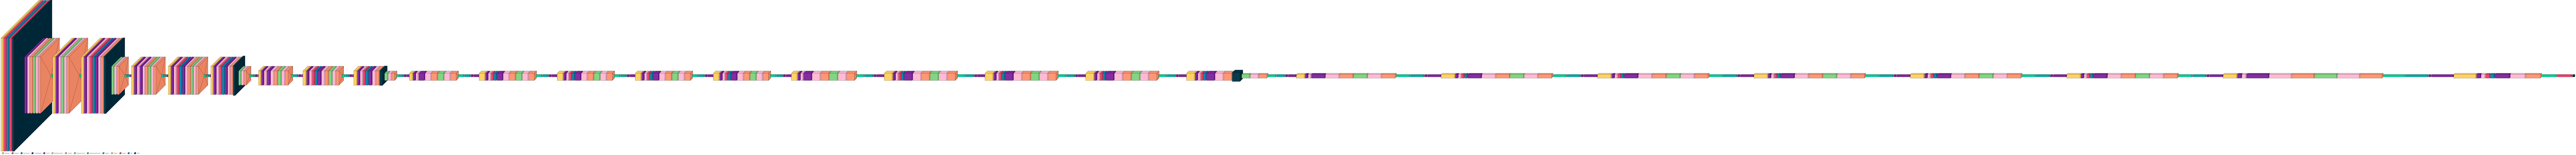

In [ ]:
# Para ver la representación gráfica
visualkeras.layered_view(model, legend=True)

No se ve una mierda pero si clickais en la imagen se agranda bastante, esta guay para explicar esta red

# Para volver a entrenar sin necesidad de repetir todo el proceso anterior

In [ ]:
# Esto nos puede ayudar a controlar el val loss
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',       # Métrica a vigilar
    factor=0.5,               # Reduce LR a la mitad
    patience=3,               # Espera 3 epochs sin mejora
    min_lr=1e-7,              # No baja más de esto
    verbose=1                 # Muestra por pantalla cuándo actúa
)

In [ ]:
# recompilar (útil para cambiar learning rate, optimizer, etc)
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
import tensorflow as tf
import numpy as np

# Cargar el modelo
modelo = tf.keras.models.load_model("modelo_multiclase_final.keras")

# Ver información general
print("📊 INFORMACIÓN DEL MODELO:")
print(f"Nombre: {modelo.name}")
print(f"Número de capas: {len(modelo.layers)}")

# Ver el input shape del modelo completo
print(f"\n🔧 INPUT SHAPE DEL MODELO:")
print(f"Input shape: {modelo.input_shape}")
print(f"Output shape: {modelo.output_shape}")

# Ver las primeras 5 capas
print(f"\n🏗️ PRIMERAS 5 CAPAS:")
for i, layer in enumerate(modelo.layers[:5]):
    # Usar output.shape en lugar de output_shape para compatibilidad
    try:
        output_shape = str(layer.output.shape)
    except:
        output_shape = "N/A"

    print(f"{i:2d}. {layer.name:20s} | Output: {output_shape:20s}")

    # Ver el kernel de la primera capa convolucional (capa 1)
    if i == 1 and hasattr(layer, 'kernel'):
        kernel_shape = layer.kernel.shape
        print(f"    ⚙️ Kernel shape: {kernel_shape}")

# Probar con diferentes shapes
print(f"\n🧪 PRUEBA DE PREDICCIÓN:")
test_shapes = [
    (1, 300, 300, 1),  # Grayscale
    (1, 300, 300, 3),  # RGB
]

for shape in test_shapes:
    print(f"Probando con shape: {shape}")
    test_input = np.random.random(shape)
    try:
        prediction = modelo.predict(test_input, verbose=0)
        print(f"✅ Funciona con shape {shape}")
        print(f"📊 Output shape: {prediction.shape}")
    except Exception as e:
        print(f"❌ Error con shape {shape}: {e}")

# Información adicional sobre el modelo
print(f"\n📋 RESUMEN DEL MODELO:")
print(f"Input shape esperado: {modelo.input_shape}")
print(f"Output shape: {modelo.output_shape}")
print(f"Total de parámetros: {modelo.count_params():,}")

# Verificar si el modelo está compilado
print(f"¿Modelo compilado?: {modelo.compiled}")

📊 INFORMACIÓN DEL MODELO:
Nombre: functional
Número de capas: 388

🔧 INPUT SHAPE DEL MODELO:
Input shape: (None, 300, 300, 3)
Output shape: (None, 4)

🏗️ PRIMERAS 5 CAPAS:
 0. input_layer          | Output: (None, 300, 300, 3) 
 1. rescaling            | Output: (None, 300, 300, 3) 
 2. normalization        | Output: (None, 300, 300, 3) 
 3. rescaling_1          | Output: (None, 300, 300, 3) 
 4. stem_conv_pad        | Output: (None, 301, 301, 3) 

🧪 PRUEBA DE PREDICCIÓN:
Probando con shape: (1, 300, 300, 1)
✅ Funciona con shape (1, 300, 300, 1)
📊 Output shape: (1, 4)
Probando con shape: (1, 300, 300, 3)
✅ Funciona con shape (1, 300, 300, 3)
📊 Output shape: (1, 4)

📋 RESUMEN DEL MODELO:
Input shape esperado: (None, 300, 300, 3)
Output shape: (None, 4)
Total de parámetros: 10,789,683
¿Modelo compilado?: True


In [ ]:
# volver a entrenar
history_2 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/50
116/845 ━━━━━━━━━━━━━━━━━━━━ 7:34 623ms/step - accuracy: 0.9916 - loss: 0.0273

KeyboardInterrupt: 

# Gráfica de Accuracy y Loss



In [ ]:
import matplotlib.pyplot as plt

def plot_training(history, title="Entrenamiento"):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Train Accuracy')
    plt.plot(epochs_range, val_acc, label='Val Accuracy')
    plt.legend()
    plt.title(f'{title} - Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Val Loss')
    plt.legend()
    plt.title(f'{title} - Loss')

    plt.show()

plot_training(history, "EfficientNetB3")

# Matriz de confusión

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
# Predicciones del modelo
y_pred_probs = model.predict(val_generator)
y_pred = np.argmax(y_pred_probs, axis=1)  # Clase con mayor probabilidad

In [ ]:
y_true = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

In [ ]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)

plt.figure(figsize=(10, 8))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Matriz de Confusión")
plt.show()

Aquí vemos algo muy importante, glioma es la clase peor predicha y justo es la clase que menos elementos tiene. Si conseguimos equilibrar esta clase junto al resto cabría esperar incluso un mejor ajuste. Aún así en nuestro caso, realmente nos interesa distinguir entre tumor o no, y si asumimos cualquier etiqueta diferente a no tumor como tumor nuestro accuracy es practicamente perfecto.

# Para predecir EL TEST

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Generador para test (sin aumentos)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Cargamos test
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False  # importante para que las predicciones correspondan a los ficheros en orden
)

# Evaluar
loss, acc = model.evaluate(test_generator)
print(f"📊 Test accuracy: {acc:.4f}")
print(f"📉 Test loss: {loss:.4f}")

#Para predecir una imagen Random

In [ ]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# 2️⃣ Cargar y preprocesar la imagen
img_path = "mmmm.png"
img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))  # tamaño usado en entrenamiento
img_array = image.img_to_array(img)                               # convertir a array
img_array = img_array / 255.0                                     # normalizar igual que en entrenamiento
img_array = np.expand_dims(img_array, axis=0)                     # añadir dimensión batch

# 3️⃣ Predecir
predicciones = model.predict(img_array)

# 4️⃣ Interpretar resultado
clase_predicha = np.argmax(predicciones, axis=1)[0]
print(f"Clase predicha: {clase_predicha}")
print(f"Probabilidades: {predicciones}")

Para esta imagen random ha acertado

In [ ]:
# Accessing class indices for training data generator
class_indices_train = train_generator.class_indices
class_indices_train_list = list(train_generator.class_indices.keys())


# Displaying categorical types
print("Categorical types for the training data:")
print(class_indices_train)